In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import silhouette_score, silhouette_samples
from tqdm import tqdm


In [34]:
def impute_within_cluster(cluster_df, column_name):
    imputer = SimpleImputer(strategy='mean')  
    cluster_df[column_name] = imputer.fit_transform(cluster_df[[column_name]])
    return cluster_df

In [35]:
data = pd.read_csv("data/Customer Data.csv")
display(data.loc[data.isna().any(axis=1)])

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,C19185,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6


In [36]:
X = data.drop(columns=['CUST_ID', 'CREDIT_LIMIT', 'MINIMUM_PAYMENTS'])
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(X)

data = data.groupby('Cluster', group_keys=False).apply(impute_within_cluster, 'CREDIT_LIMIT')
data.drop(columns=['Cluster'], inplace=True)

X = data.drop(columns=['CUST_ID', 'MINIMUM_PAYMENTS'])
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(X)

data = data.groupby('Cluster', group_keys=False).apply(impute_within_cluster, 'MINIMUM_PAYMENTS')
data.drop(columns=['Cluster'], inplace=True)

In [37]:
data.shape

(8950, 18)

In [38]:
data.loc[data.isna().any(axis=1)]  # no Missing Values

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


C:\Users\vince\AppData\Local\Temp\ipykernel_34552\3692320006.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(data.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5, figsize=(15, 15))


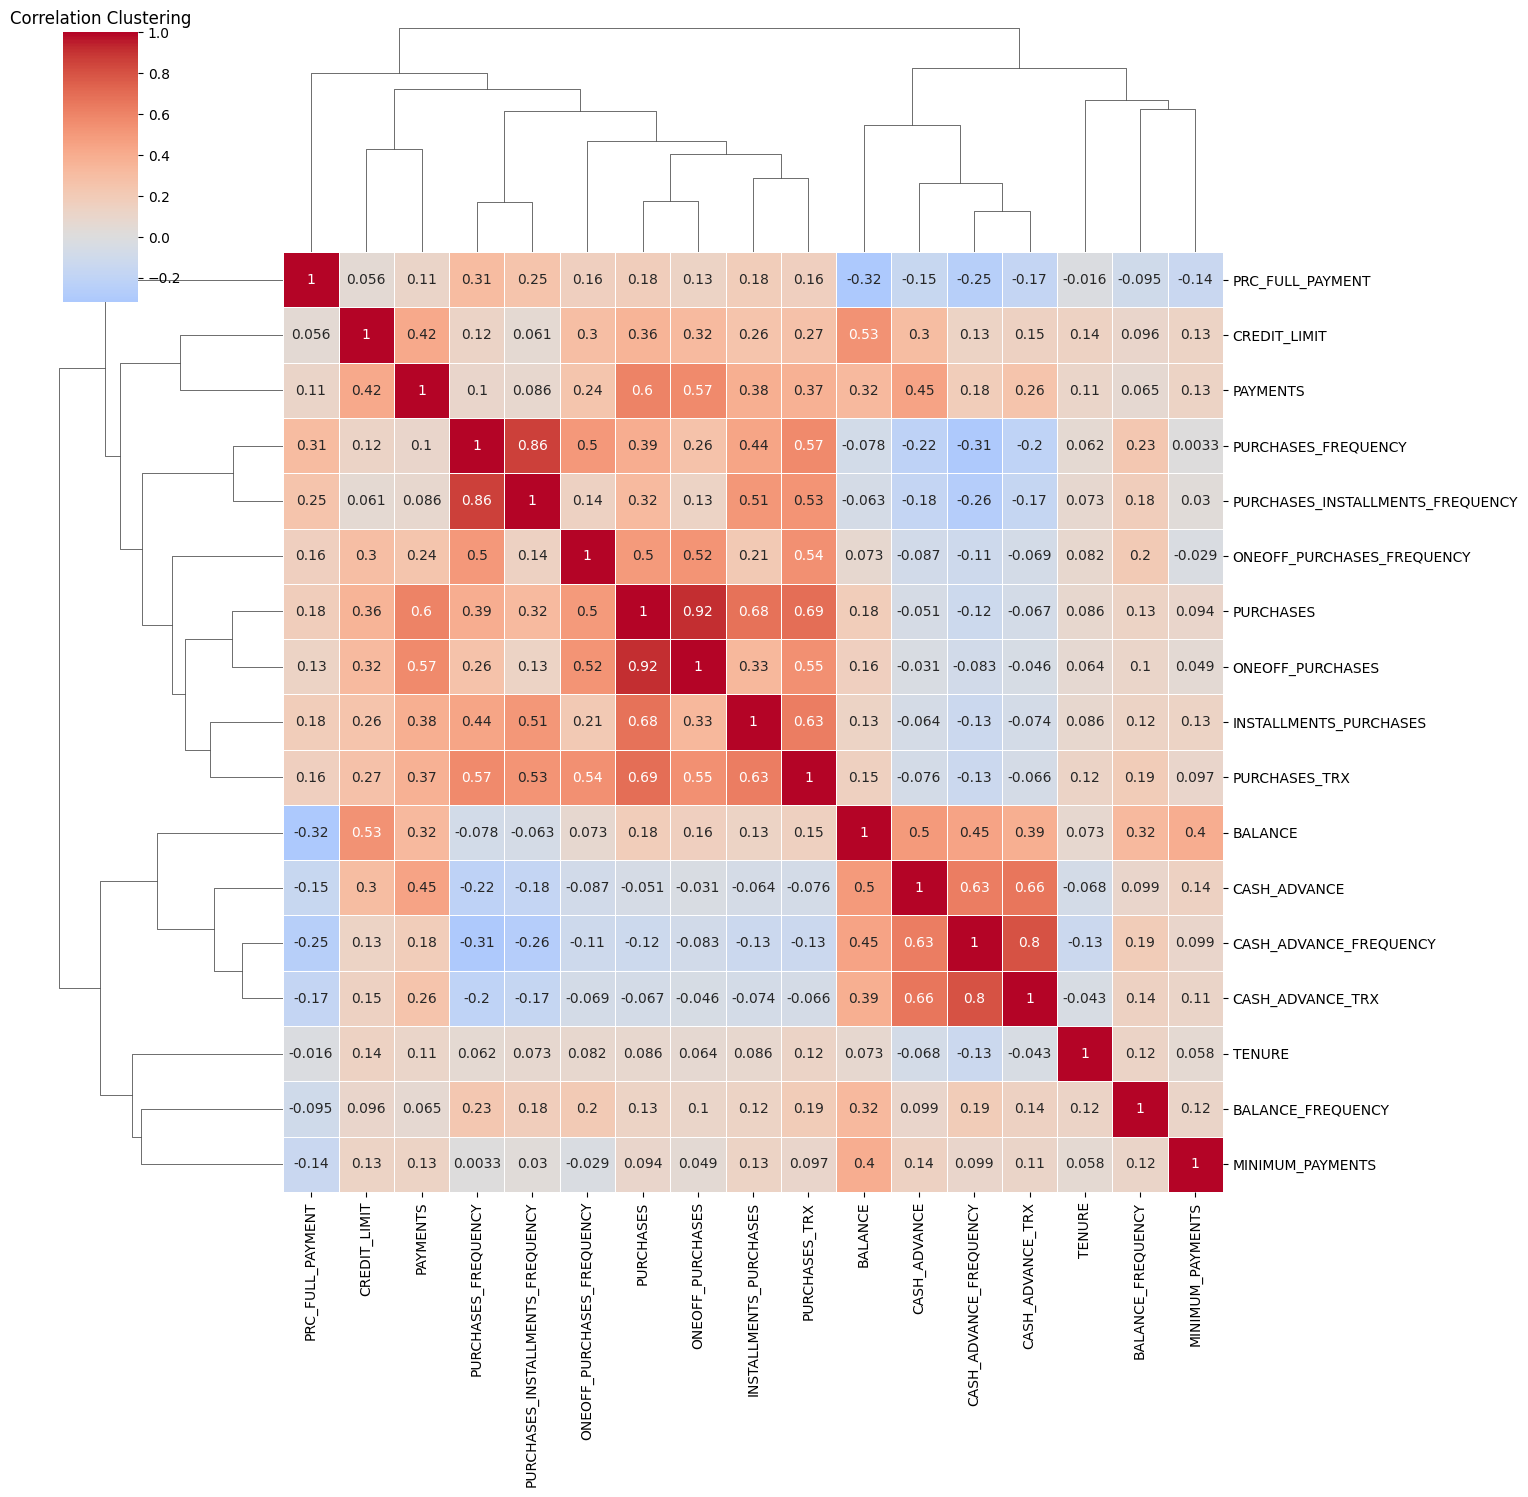

In [39]:
sns.clustermap(data.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5, figsize=(15, 15))
plt.title('Correlation Clustering')
plt.show()

In [40]:
data['CREDIT_UTILIZATION'] = data['BALANCE'] / data['CREDIT_LIMIT']
data['DEBT_TO_PAYMENT_RATIO'] = np.where(data['PAYMENTS'] == 0, 0, data['BALANCE'] / data['PAYMENTS'])
data['PURCHASE_TO_LIMIT'] = data['PURCHASES'] / data['CREDIT_LIMIT']
data['PAYMENT_CONSISTENCY'] = data['PAYMENTS'] / (data['BALANCE'] + 1)  # avoid division by zero
data['CASH_ADVANCE_TO_PURCHASES'] = data['CASH_ADVANCE'] / (data['PURCHASES'] + 1) # same
data['ENGAGEMENT_INDEX'] = (
    data['PURCHASES_FREQUENCY'] +
    data['ONEOFF_PURCHASES_FREQUENCY'] +
    data['PURCHASES_INSTALLMENTS_FREQUENCY'] +
    data['CASH_ADVANCE_FREQUENCY']
)
data['RISK_SCORE'] = (
    (data['CREDIT_UTILIZATION'] > 0.8).astype(int) +
    (data['CASH_ADVANCE_TO_PURCHASES'] > 0.5).astype(int) +
    (data['PAYMENT_CONSISTENCY'] < 0.3).astype(int) +
    (data['DEBT_TO_PAYMENT_RATIO'] > 1.5).astype(int)
)
data['RISKY_CUSTOMER'] = (data['RISK_SCORE'] >= data['RISK_SCORE'].max() * 0.95)  # risky if score >= threshold = 5% of the maximum score

data['OUTSTANDING_SCORE'] = (
    (data['CREDIT_UTILIZATION'] < 0.3).astype(int) +
    (data['PAYMENT_CONSISTENCY'] > 0.8).astype(int) +
    (data['CASH_ADVANCE_TO_PURCHASES'] < 0.2).astype(int)
)
data['OUTSTANDING_CUSTOMER'] = (data['OUTSTANDING_SCORE'] >= data['OUTSTANDING_SCORE'].max() * 0.95)  # outstanding if score >= threshold = 5% of the maximum score


100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


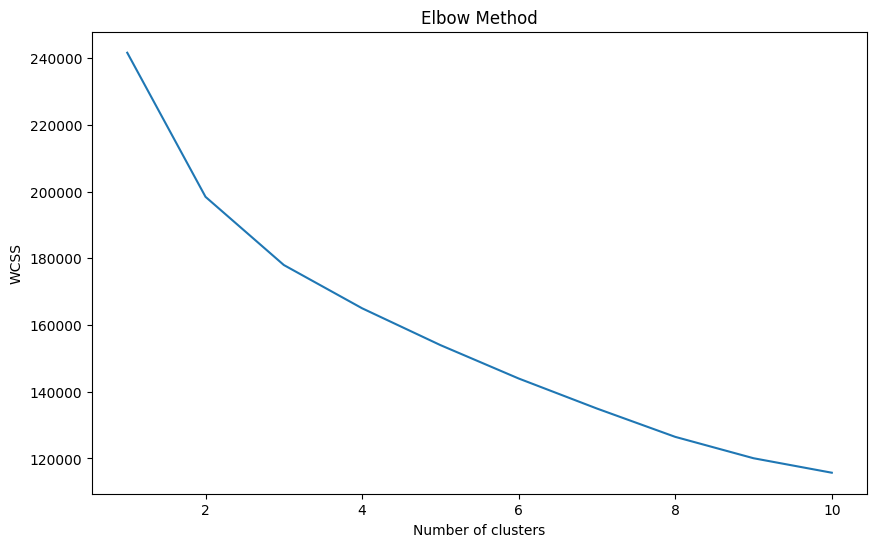

Silhouette Score: 0.19056650803312764


C:\Users\vince\AppData\Local\Temp\ipykernel_34552\3405927657.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_analysis = data.groupby('Cluster').mean()


In [41]:
features = data.drop(columns=['CUST_ID']).columns
X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_cluster_max = 10
wcss = []
for i in tqdm(range(1, n_cluster_max + 1)):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_cluster_max + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

cluster_analysis = data.groupby('Cluster').mean()

  0%|          | 0/5 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.2121774301768995


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

For n_clusters = 3 The average silhouette_score is : 0.19807708242947505


 40%|████      | 2/5 [00:04<00:07,  2.45s/it]

For n_clusters = 4 The average silhouette_score is : 0.19057804956031946


 60%|██████    | 3/5 [00:07<00:04,  2.42s/it]

For n_clusters = 5 The average silhouette_score is : 0.18832356626145388


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

For n_clusters = 6 The average silhouette_score is : 0.2080483451129909


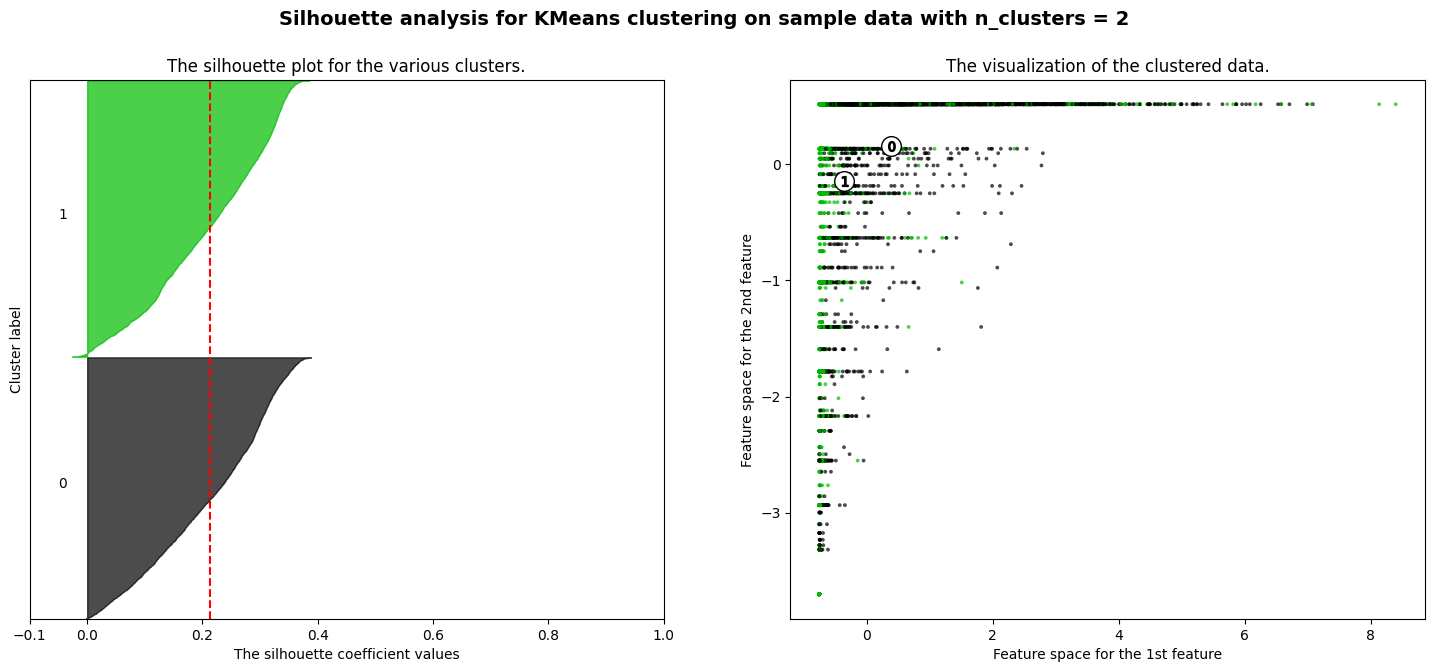

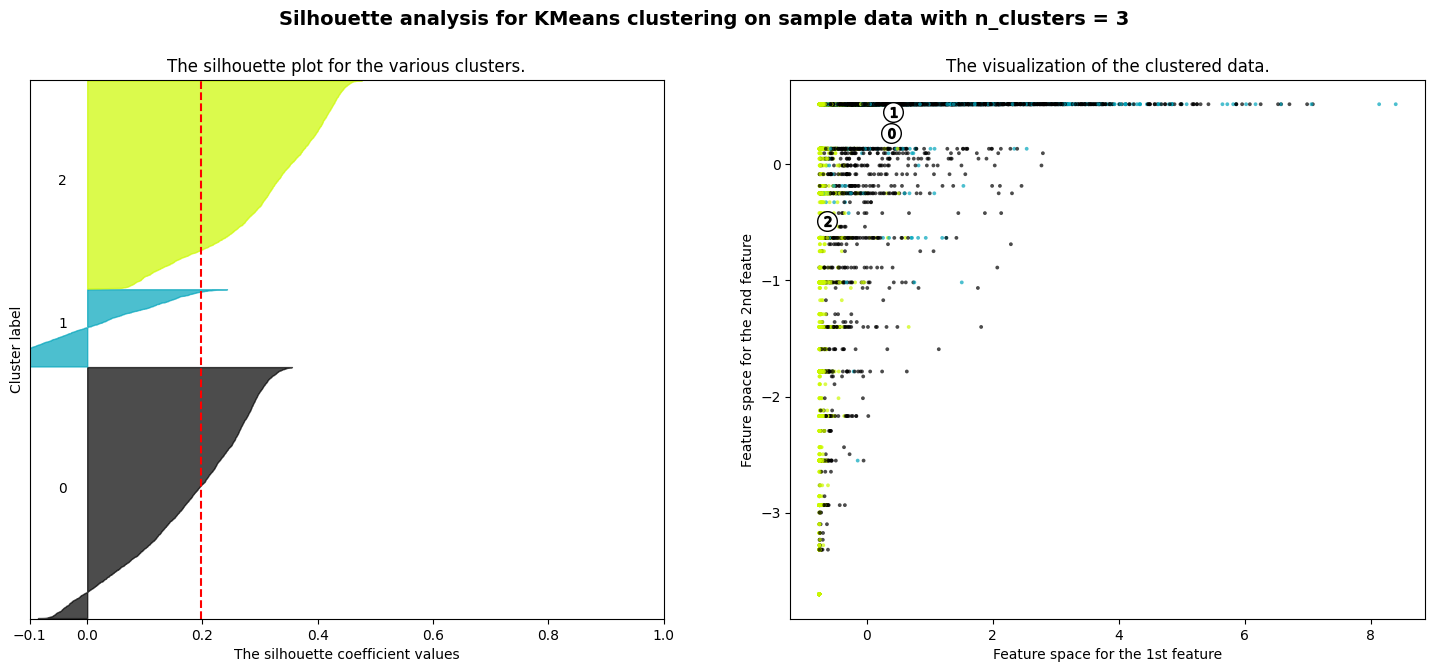

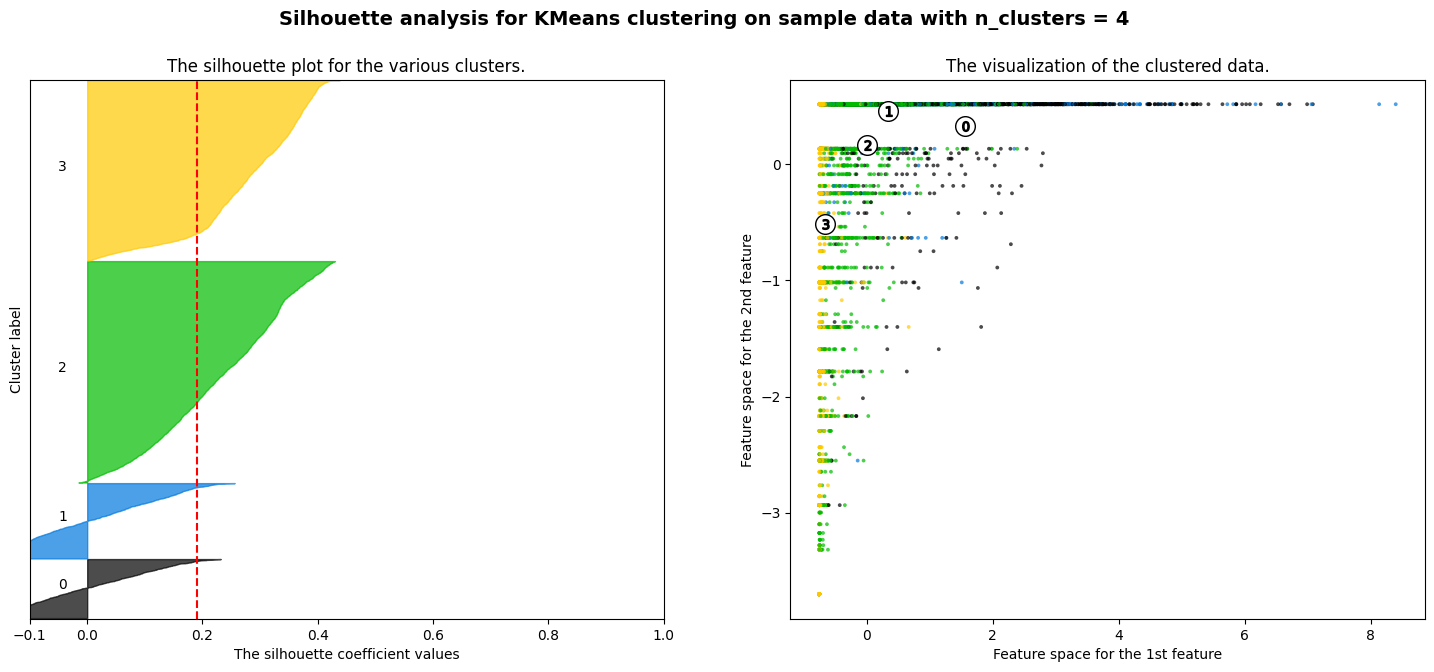

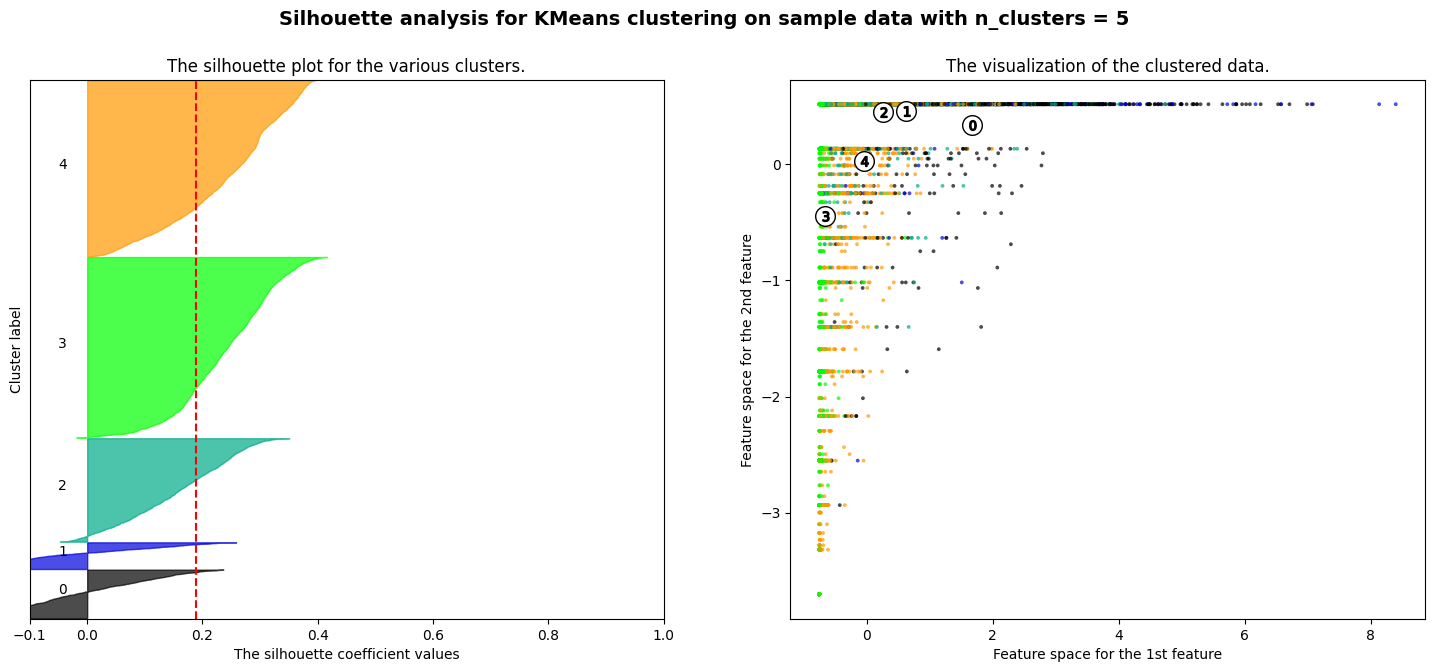

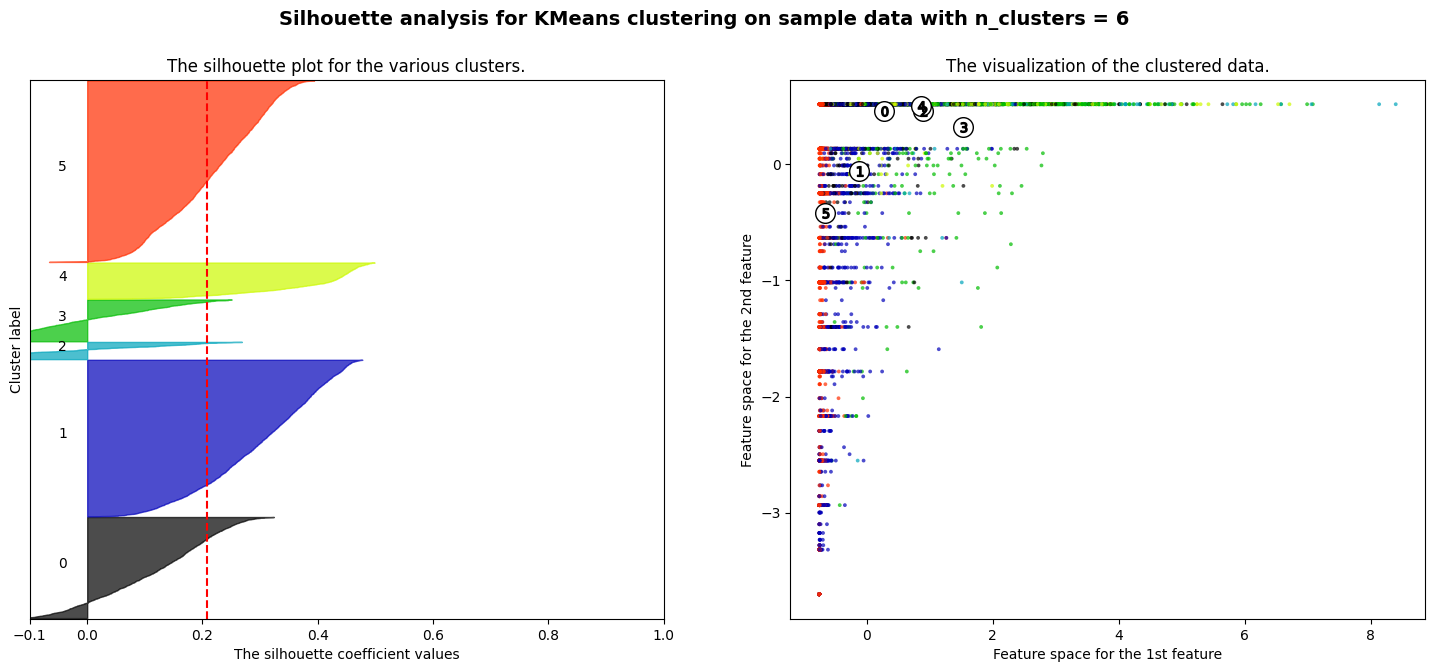

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(data[features])
y = data['Cluster']

range_n_clusters = range(2, 7)
for n_clusters in tqdm(range_n_clusters, leave=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10, max_iter=300)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [43]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
X_embedded.shape

(8950, 2)

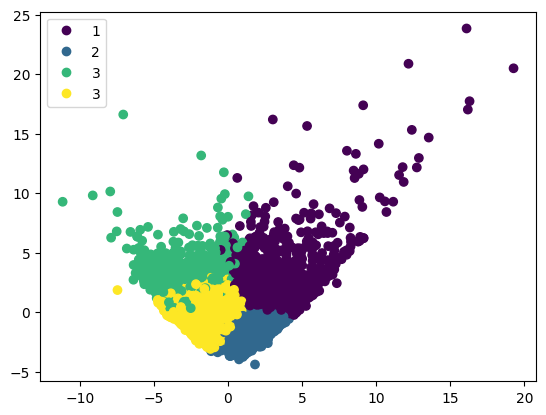

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y))
plt.show()

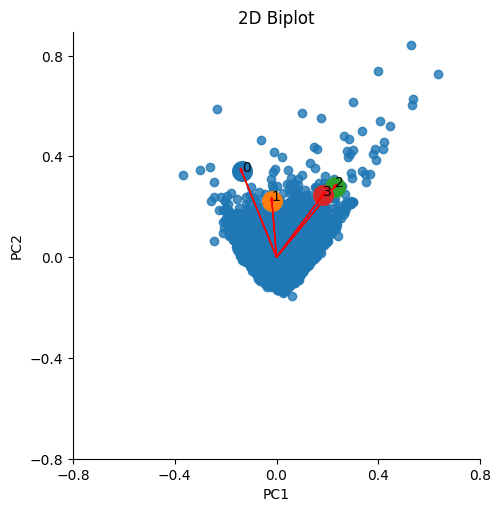

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

loadings = pca.components_
n_features = pca.n_features_in_

pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

pc_loadings = dict(zip(pc_list, loadings))
loadings_df = pd.DataFrame.from_dict(pc_loadings)


xs = loadings[0]
ys = loadings[1]

pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])

target_names = {
    0:'setosa',
    1:'versicolor', 
    2:'virginica'
}

pca_df['target'] = y
pca_df['target'] = pca_df['target'].map(target_names)

pca_df_scaled = pca_df.copy()
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min())

for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]


xs = loadings[0]
ys = loadings[1]

sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df_scaled, 
    fit_reg=False, 
    )

for i, varnames in enumerate(range(4)):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0,
        xs[i], 
        ys[i], 
        color='r', 
        head_width=0.01
        )
    plt.text(xs[i], ys[i], varnames)

xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('2D Biplot')
plt.show()

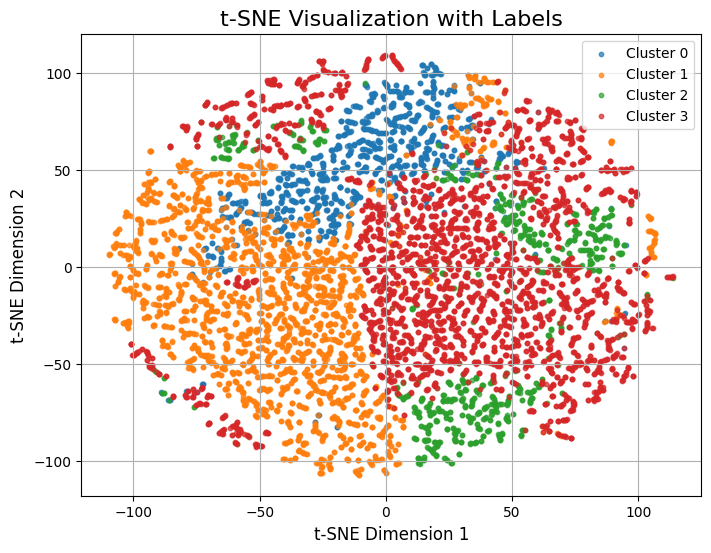

In [ ]:
unique_labels = np.unique(y)

plt.figure(figsize=(8, 6))
for label in unique_labels:
    idx = y == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=f"Cluster {label}", s=10, alpha=0.7)

plt.title("t-SNE Visualization with Labels", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [47]:
data.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'CREDIT_UTILIZATION',
       'DEBT_TO_PAYMENT_RATIO', 'PURCHASE_TO_LIMIT', 'PAYMENT_CONSISTENCY',
       'CASH_ADVANCE_TO_PURCHASES', 'ENGAGEMENT_INDEX', 'RISK_SCORE',
       'RISKY_CUSTOMER', 'OUTSTANDING_SCORE', 'OUTSTANDING_CUSTOMER',
       'Cluster'],
      dtype='object')

C:\Users\vince\AppData\Local\Temp\ipykernel_34552\2075123911.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = data.groupby('Cluster').mean()


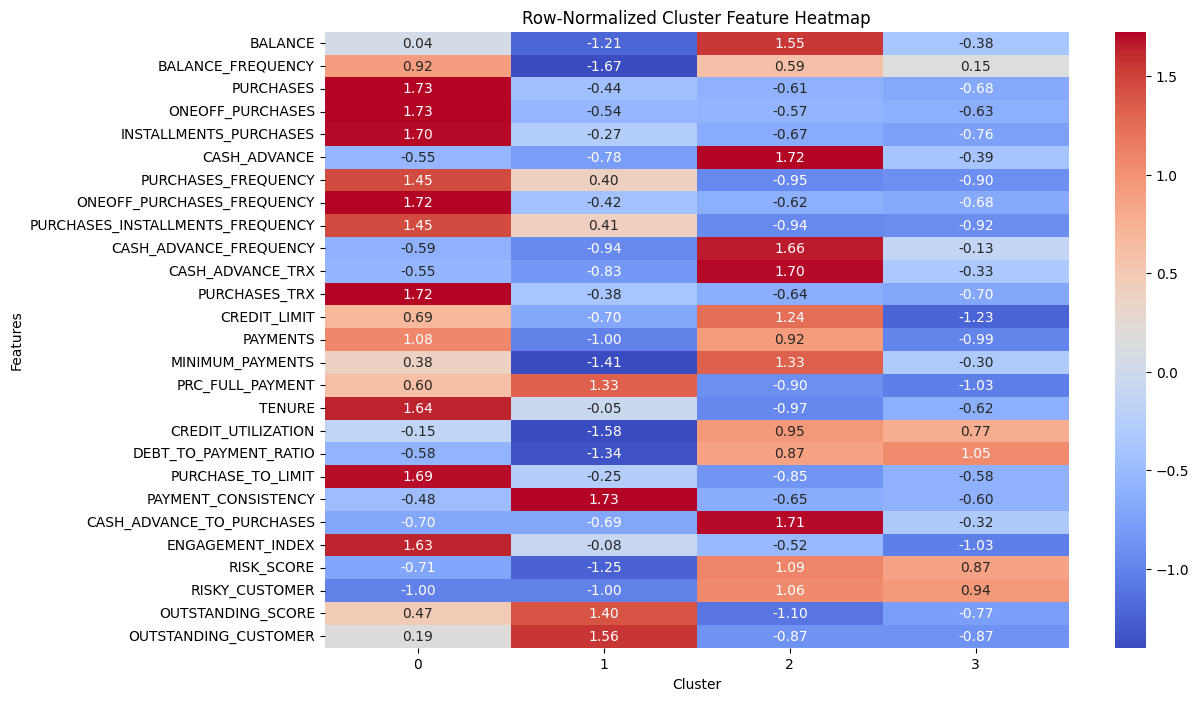

In [48]:
cluster_means = data.groupby('Cluster').mean()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_means_normalized = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    index=cluster_means.index,
    columns=cluster_means.columns
)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_normalized.T, annot=True, cmap='coolwarm', fmt='.2f', robust=True)
plt.title('Row-Normalized Cluster Feature Heatmap')
plt.ylabel('Features')
plt.xlabel('Cluster')
plt.show()


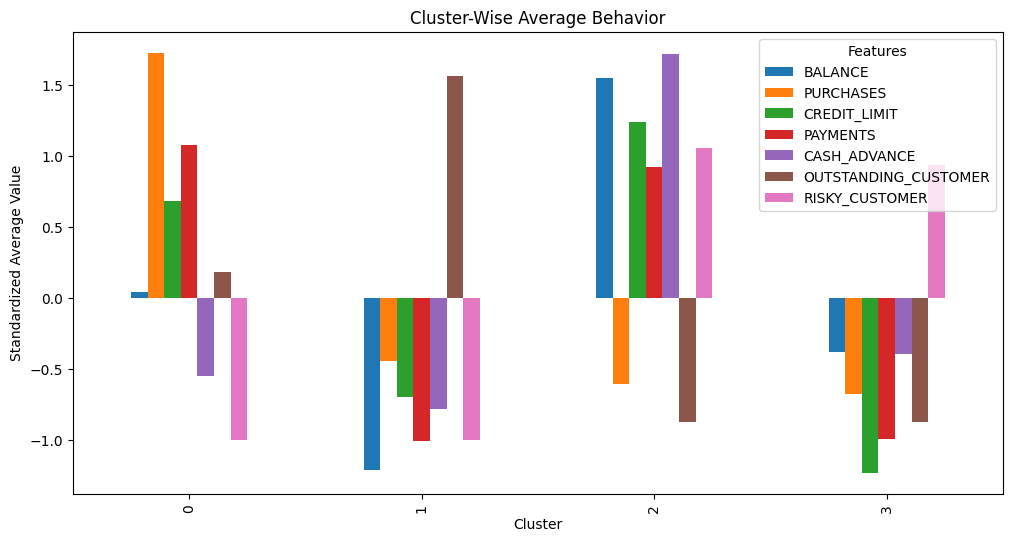

In [50]:
# cluster_summary = data.groupby('Cluster').mean()

features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'CASH_ADVANCE', 'OUTSTANDING_CUSTOMER', 'RISKY_CUSTOMER']
cluster_means_normalized[features].plot(kind='bar', figsize=(12, 6))
plt.title('Cluster-Wise Average Behavior')
plt.xlabel('Cluster')
plt.ylabel('Standardized Average Value')
plt.legend(title='Features')
plt.show()


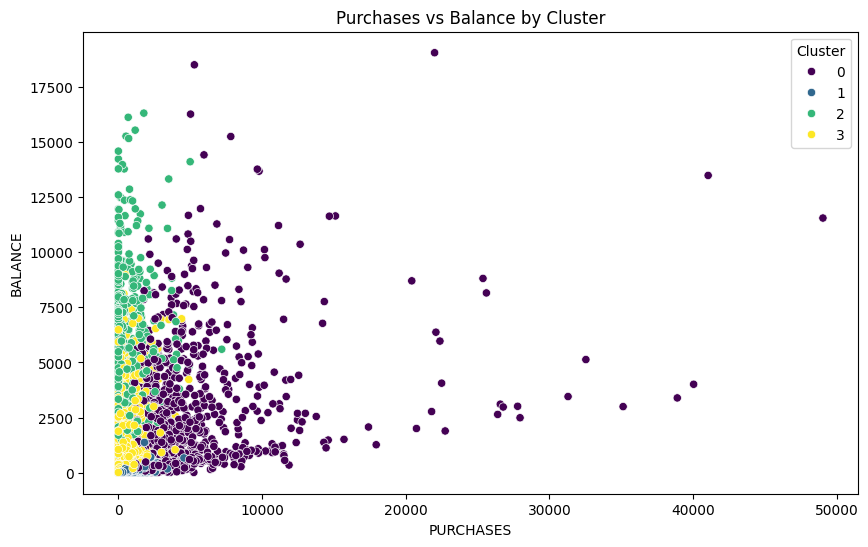

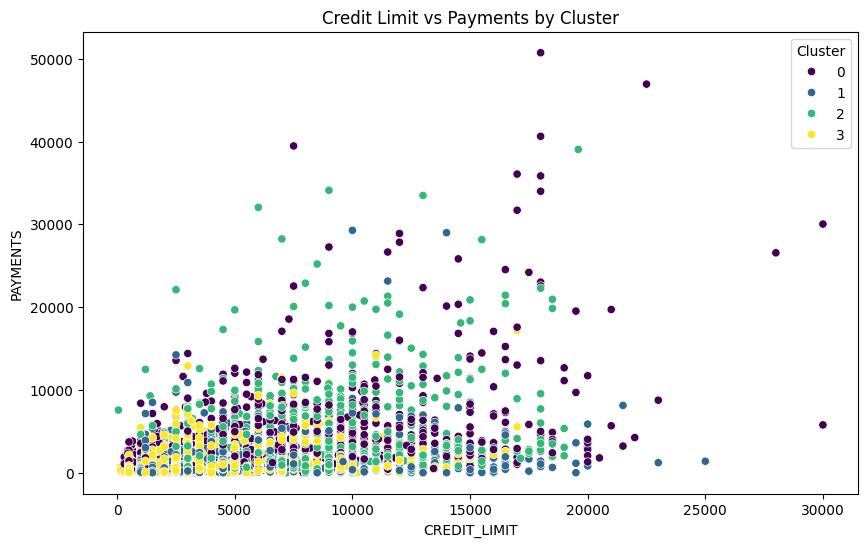

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PURCHASES', y='BALANCE', hue='Cluster', data=data, palette='viridis')
plt.title('Purchases vs Balance by Cluster')
plt.xlabel('PURCHASES')
plt.ylabel('BALANCE')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='CREDIT_LIMIT', y='PAYMENTS', hue='Cluster', data=data, palette='viridis')
plt.title('Credit Limit vs Payments by Cluster')
plt.xlabel('CREDIT_LIMIT')
plt.ylabel('PAYMENTS')
plt.legend(title='Cluster')
plt.show()


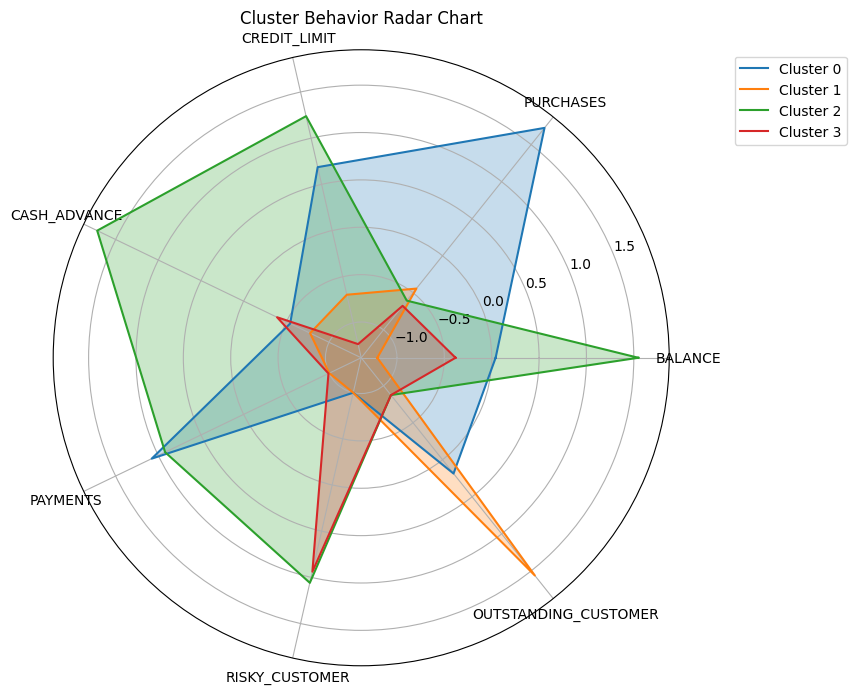

In [55]:
from math import pi

features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'CASH_ADVANCE', 'PAYMENTS', 'RISKY_CUSTOMER', 'OUTSTANDING_CUSTOMER']
num_clusters = len(data['Cluster'].unique())
angles = np.linspace(0, 2 * pi, len(features), endpoint=False).tolist()

angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for cluster in range(num_clusters):
    values = cluster_means_normalized.loc[cluster, features].values.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), features)
plt.title('Cluster Behavior Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()